# Spotify Analysis
Analyze some cool data from the spotify api of 27 manually chosen artists

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PolynomialFeatures
import random
from tabulate import tabulate


def numeric_date(date):
    d = str(date)
    return int(d[0:4] + d[5:7] + d[8:10])

def getyear_date(date):
    d = str(date)
    return int(d[0:4])
# ------------------------------------------
ds = pd.read_csv('tracks.csv')
ds.columns
# ------------------------------------------
# https://developer.spotify.com/

Index(['Unnamed: 0', 'Number', 'ID', 'Name', 'Duration', 'Popularity',
       'isLocal', 'isExplicit', 'Album Name', 'Album ID', 'Album Track Count',
       'Album Release Date', 'Artist Name', 'Artist ID', 'Artist Popularity',
       'Artist Genres', 'Artist Followers Count'],
      dtype='object')

### Graph Below: 
Each artist and their:
- popularity amongst all spotify listeners (blue) ranked 0 - 100
- Song Popularity Average (Orange) ranked 0 - 100
- Followers Count (Green) ranked with heighest = 100, lowest = ~0

<ipython-input-138-a0f8e990dd91>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_['Artist Followers Count'] = ((100 * ds_['Artist Followers Count']) / ds_['Artist Followers Count'].max())


<AxesSubplot:xlabel='Artist Name'>

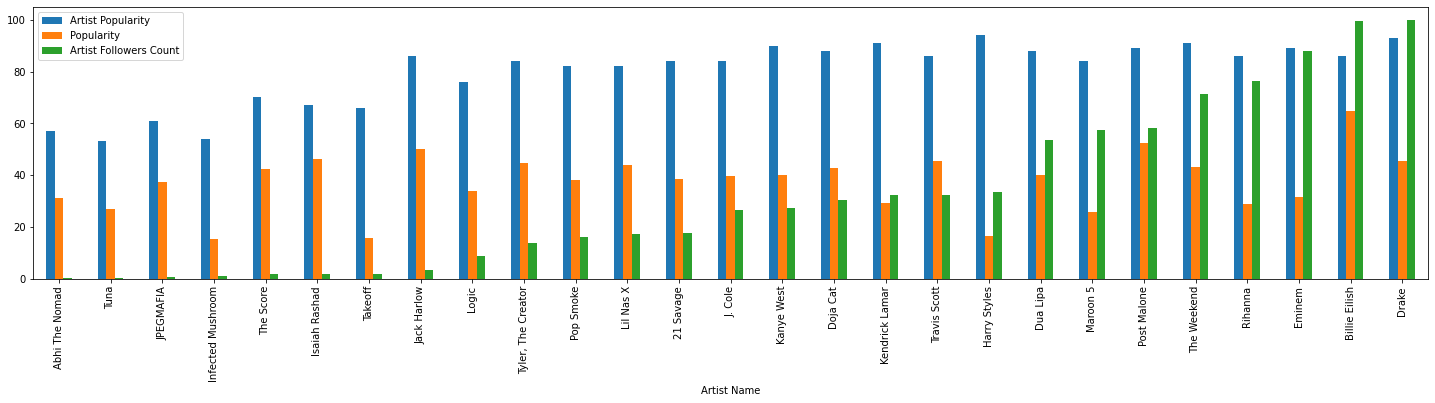

In [138]:
ds_ = ds[['Artist Name', 'Artist Popularity', 'Popularity', 'Artist Followers Count']]

ds_['Artist Followers Count'] = ((100 * ds_['Artist Followers Count']) / ds_['Artist Followers Count'].max())
artists = set(ds_['Artist Name'])
ds_.groupby('Artist Name').mean().sort_values(['Artist Followers Count', 'Artist Popularity', 'Popularity'],ascending=True).plot(kind='bar', figsize=(25,5))


### Graph Below:
Shows a scatter distribution of each song's duration (x-axis) vs it's popularity.
Objective: see if there exists a relationship between the duration of a song and it's popularity anobst spotify listeners
Color mapping represents the clusters of the tracks. 
- The more RED: the more the track represented by the dot is followed by the universal trend
- The more BLUE: the more of an anomaly it is and it is not within the common trend of the scatter plot

The line graphed represens the curve of athe relationship between the two and will therefore allow us to determine the gaussian ditribution

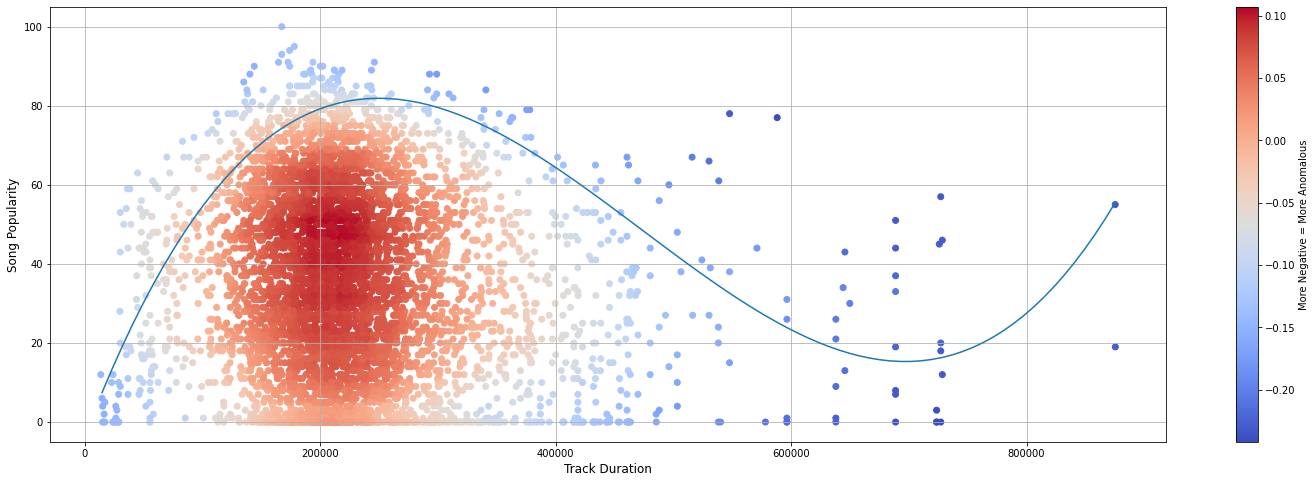

In [149]:
ds_ = ds[['Duration' ,'Popularity']] #for now
ds_ = ds_[ds['Duration'] < 1000000]
model = ensemble.IsolationForest().fit(ds_)
# Get Anomaly Scores and Predictions
anomaly_score = model.decision_function(ds_)
predictions = model.predict(ds_)

#find anomalies and plot a line over them
x, y = [], []
for i in range(len(ds_['Duration'])):
    if anomaly_score[i] < -0.15:
        x.append(ds_['Duration'].iloc[i])
        y.append(ds_['Popularity'].iloc[i])

linemodel = np.poly1d(np.polyfit(x, y, 3))
line = np.linspace(min(x), max(x), 100)

# ------------------------- Visualize -----------------------
plt.figure(figsize = (25, 8))
s = plt.scatter(ds_['Duration'], ds_['Popularity'], c = anomaly_score, cmap = 'coolwarm')
plt.colorbar(s, label = 'More Negative = More Anomalous')
plt.plot(line, linemodel(line))
plt.xlabel('Track Duration', fontsize = 12)
plt.ylabel('Song Popularity', fontsize = 12)
plt.grid()

### Graph Below:
Represented the relationship betweem each artist's popularity by all spotify listeners against it's number of followers on spotify.
There is defintely a strong trend which we see grows recrusively to an extend: the more popular the artist is (accoridng to spotify) the more likely it is to have more followers, and vice versa and presented by this direct-eponential relationship/

NOTE: keep in mind that we're only using a 27 artist point sample, therefore the relationship derived cannot be relied on fully and is not completely accurate.
To get a more accurate line plot, add more artists to the database.

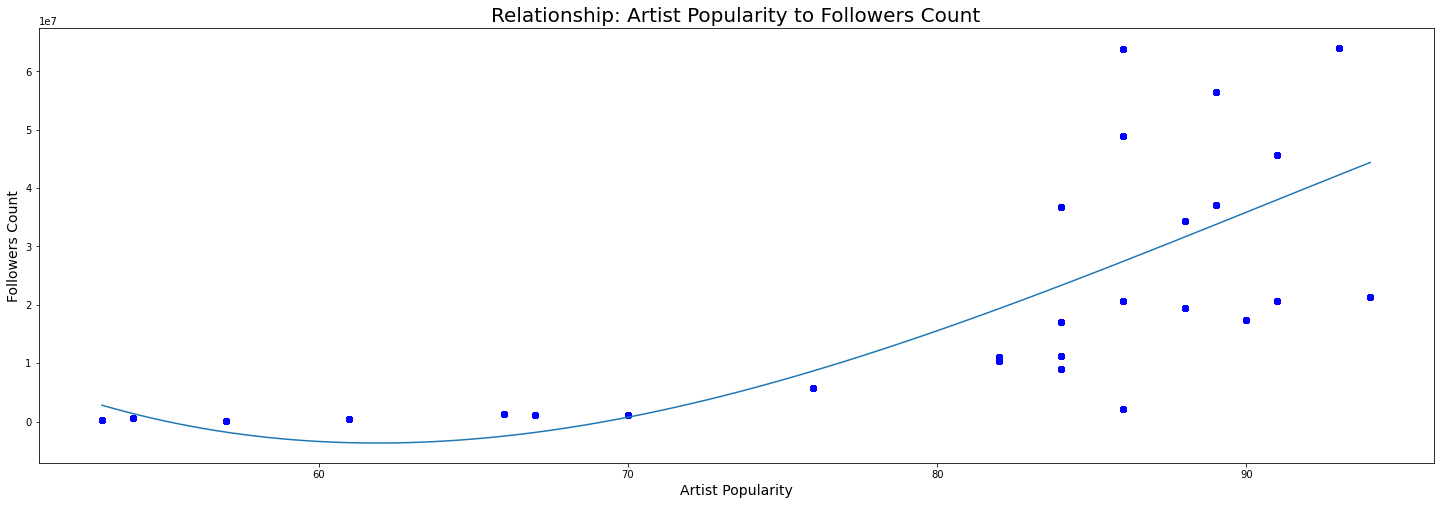

In [140]:
ds_ = ds[['Artist Name', 'Artist Followers Count', 'Artist Popularity']]
# ds_.sort_values(by = 'Artist Followers Count')
x = ds_['Artist Name']
y1 = ds_['Artist Followers Count']
y2 = ds_['Artist Popularity']

model = np.poly1d(np.polyfit(y2, y1, 3))
line = np.linspace(ds_['Artist Popularity'].min(), ds_['Artist Popularity'].max(), 100)

plt.figure(figsize = (25, 8))
plt.scatter(y2, y1, color = "b")
plt.plot(line, model(line))
plt.xlabel("Artist Popularity", fontsize = 14)
plt.ylabel("Followers Count", fontsize = 14)
plt.title('Relationship: Artist Popularity to Followers Count', fontsize = 20)
plt.show()

### Graph Below:
Shows the popularity of each group of tracks. Some songs on spotify are explicit (with curse words in it) and some are not.
It answers the question: are explicit songs (labeled as True) more popular?

<AxesSubplot:title={'center':'Are Explicit and Local Songs More Popular?'}, xlabel='Explicit Track', ylabel='Average Popularity'>

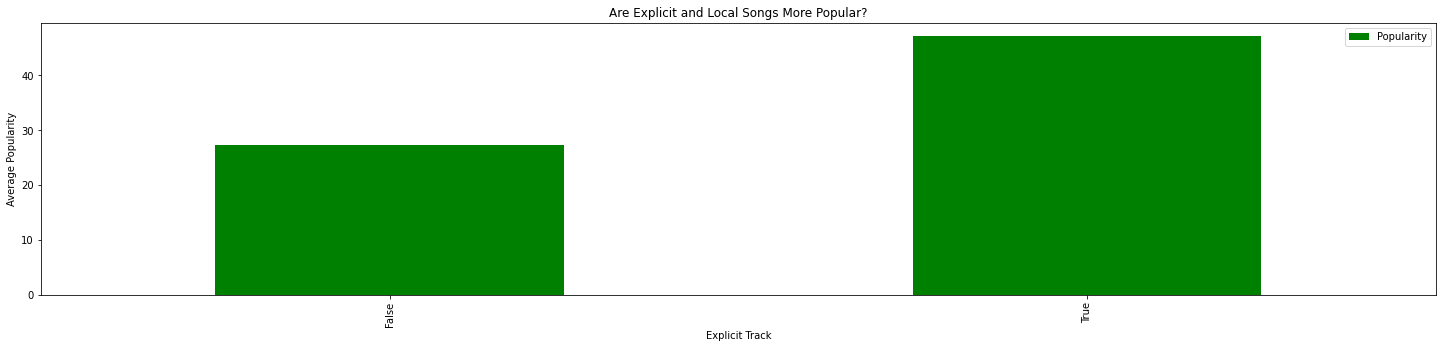

In [141]:
ds_ = ds[['isExplicit', 'Popularity']]
ds_.groupby('isExplicit').mean().sort_values(['Popularity'],ascending=True).plot(kind='bar', figsize=(25,5), 
            color = 'green',
            xlabel = 'Explicit Track', 
            ylabel = 'Average Popularity',
            title = 'Are Explicit and Local Songs More Popular?')


### Graph Below:

Consider a metric: mean annual track score

For each artist the graph represents the average of each song release at each year (based on the Albu, Release Date data).
One problem I had: how do I remove duplicates properly? Sometimes artists release the same song in a later date under a different cover or album, which gets a different (and often lower) popularity rate.

To give artists the continuoues benefit of the doubt and get the maxed average, I dropped any duplicated with lower popularity rate. When dropping the duplicates I was also careful not to drop any songs that share the same name but with different artists.

Additionaly, each dashed line marks the average of each artist's track popularity average throughout the years

I also graphed the number of tracks released ecah year by each artist, to see the correlation between that average popularity of each song each year and the number of tracks released. My guess is probably only a limit of 2 - 5 of each artist goes viral and becomes popular. Therefore the more songs you release the worse your popularity record is.

In [82]:
colors = ['red', 'blue', 'green', 'black', 'orange', 'pink']
ds_ = ds[['Artist Name', 'Name', 'Album Release Date', 'Popularity']]


ds_['Album Release Date'] = list(map(lambda x: getyear_date(x) ,ds_['Album Release Date']))
data = pd.DataFrame(columns = ['Artist', 'Year', 'AvgPopularity', 'TrackCount'])

ds_ = ds_.sort_values(['Name', 'Popularity'], ascending = [False, False])
ds_ = ds_.drop_duplicates(['Artist Name', 'Name'])
avgp = round(ds_.groupby(['Album Release Date', 'Artist Name'], as_index = False)['Popularity'].mean(), 2)
countp = ds_.groupby(['Album Release Date', 'Artist Name'], as_index = False)['Name'].count()
data = pd.DataFrame({'Artist': avgp['Artist Name'], 'Year': avgp['Album Release Date'], 'AvgPopularity': avgp['Popularity'], 'TrackCount': countp['Name']})
# print(tabulate(data, headers='keys', tablefmt='psql'))

<ipython-input-82-9bbc14bcfdca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_['Album Release Date'] = list(map(lambda x: getyear_date(x) ,ds_['Album Release Date']))


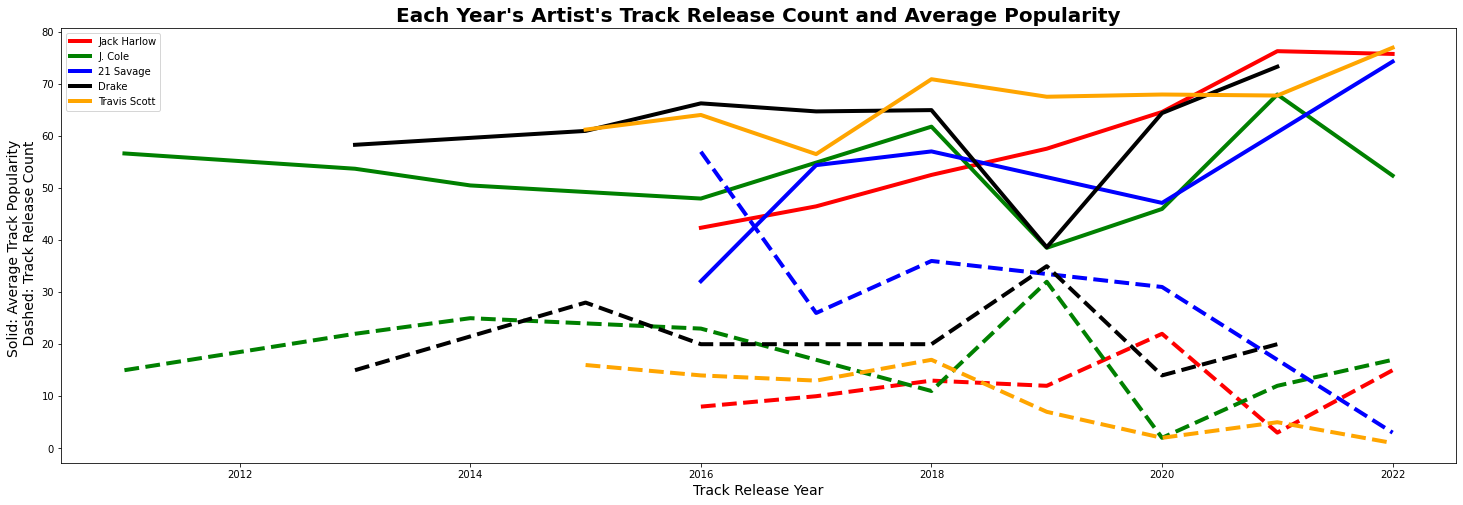

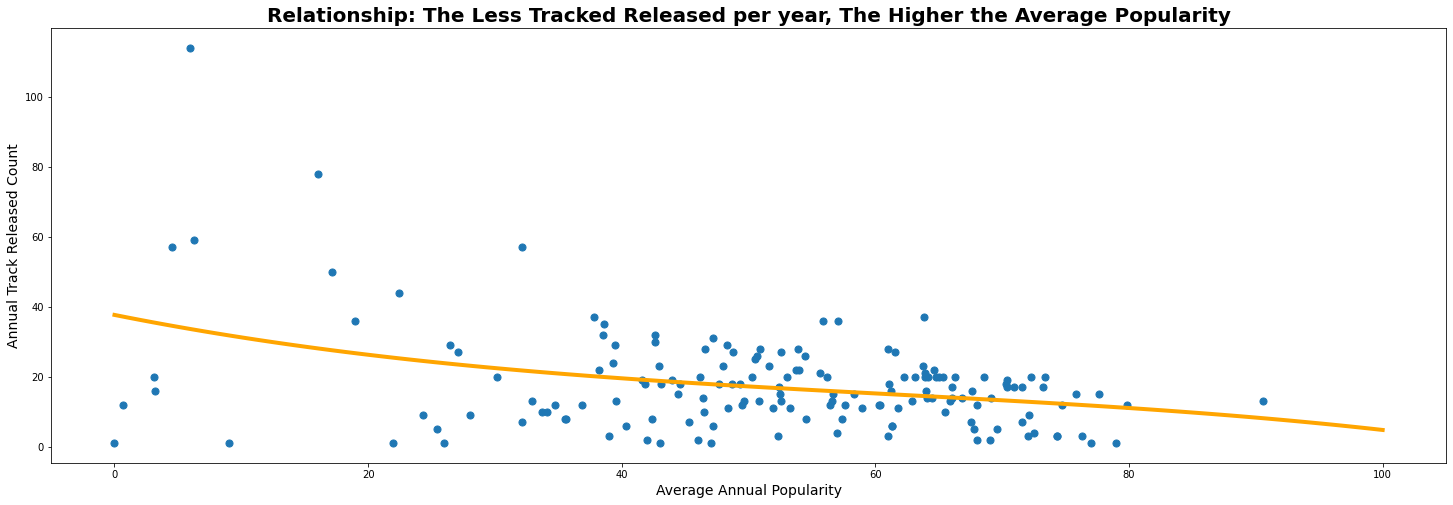

In [84]:
colors = ['red', 'blue', 'green', 'black', 'orange']
artists = ['Jack Harlow', 'J. Cole', '21 Savage', 'Drake', 'Travis Scott']

plt.figure(figsize = (25, 8))
for a in artists:
    d = data[data['Artist'] == a]
    coll = random.choice(colors)
    colors.remove(coll)
    x, y, z = d['Year'], d['AvgPopularity'], d['TrackCount']
    plt.plot(x, y, label = a, linewidth = 4, color = coll)
    plt.plot(x, z, linewidth = 4, linestyle = 'dashed', color = coll)
plt.legend(loc = 0, frameon = 'legend_drawn_flag')
plt.xlabel("Track Release Year", fontsize = 14)
plt.ylabel("Solid: Average Track Popularity \n Dashed: Track Release Count", fontsize = 14)
plt.title("Each Year's Artist's Track Release Count and Average Popularity", fontsize = 20, weight = 'bold')
plt.show()


x, y, z = data['Year'], data['AvgPopularity'], data['TrackCount']
linemodel = np.poly1d(np.polyfit(y, z, 3))
line = np.linspace(0, 100, 100)

plt.figure(figsize = (25, 8))
plt.scatter(y, z, s = 50)
plt.plot(line, linemodel(line), linewidth = 4, color = 'orange')
plt.xlabel("Average Annual Popularity", fontsize = 14)
plt.ylabel("Annual Track Released Count", fontsize = 14)
plt.title("Relationship: The Less Tracked Released per year, The Higher the Average Popularity", fontsize = 20, weight = 'bold')
plt.show()